# env 및 langsmith 

In [181]:
from dotenv import load_dotenv
from langsmith import Client

load_dotenv()
client = Client()

True

# 그래프 상태 정의

In [182]:
from typing import TypedDict
class RealEstateState(TypedDict): # 그래프의 상태를 정의하는 클래스
    real_estate_type: str  # 부동산 유형 (예: 아파트, 상가)
    questions: list[str]        # 유저 질문
    query: str             # 생성된 SQL 쿼리
    results: list[dict]          # 쿼리 결과

# 필터, 재질문 노드 생성 및 조건부 엣지

In [183]:
from langgraph.graph import StateGraph, START, END
from langchain.prompts import PromptTemplate
from langchain_openai.chat_models.base import ChatOpenAI
# Step 1: LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.8)
# Step 2: StateGraph 정의
graph = StateGraph(RealEstateState)
# Step 3: 노드 정의
## 필터링 노드
def filter_node(state: RealEstateState) -> RealEstateState :
    filter_prompt = PromptTemplate(
        input_variables=["questions"],
        template=""" '{questions}'이 부동산과 관련된 질문인지를 파악하고 다음과 같은 규칙을 지켜라
        1. 부동산 관련 질문이 아니면 'None'을 반환해라
        2. 부동산 관련 질문 중 에서 매매면 '매매'를 반환해라
        3. 전세 그리고 월세랑 관련된 질문이면 '전월세'를 반환해라.
        """)
    prompt=filter_prompt.format(questions=state["questions"])
    response = llm(messages=[{"role": "system", "content": prompt}])
    real_estate_type = response.content
    return RealEstateState(real_estate_type=real_estate_type)
def re_questions(state: RealEstateState) -> RealEstateState:
    print("=================================")
    print("[re_questions] 질문이 부동산 관련이 아니거나 제대로 인식되지 않았습니다.")
    new_question = input("새로운 부동산 질문을 입력해주세요: ")
    print("=================================")
    # 수정된 질문을 state에 업데이트
    return RealEstateState(questions=new_question)
def fiter_router(state: RealEstateState):
    # This is the router
    real_estate_type = state["real_estate_type"]
    if real_estate_type == "매매":
        return "매매"
    elif real_estate_type == "전월세":
        return "전월세"
    else:
        return 'None'

# DB 생성

In [184]:
from langchain_community.utilities import SQLDatabase
from langchain_experimental.sql import SQLDatabaseChain
import sqlite3
from langchain_community.utilities.sql_database import SQLDatabase
from sqlalchemy import create_engine
from sqlalchemy.pool import StaticPool
def get_db_engine(db_path):
    """로컬 SQLite DB 파일과 연결된 엔진을 생성합니다."""
    try:
        # SQLite DB 파일과 연결
        connection = sqlite3.connect(db_path, check_same_thread=False)
        # SQLAlchemy 엔진 생성
        engine = create_engine(
            f"sqlite:///{db_path}",
            poolclass=StaticPool,
            connect_args={"check_same_thread": False}
        )
        return engine
    except Exception as e:
        print(f"데이터베이스 연결 중 오류 발생: {str(e)}")
        return None
# DB 파일 경로 지정
db_path = './data/real_estate.db'
engine = get_db_engine(db_path)
db = SQLDatabase(
    engine,
    sample_rows_in_table_info=False  # 샘플 행 조회 비활성화
)
sql_chain = SQLDatabaseChain(llm=llm, database=db, verbose=True)

c:\Users\USER\anaconda3\envs\nlp\lib\site-packages\langchain_experimental\sql\base.py:77: UserWarning: Directly instantiating an SQLDatabaseChain with an llm is deprecated. Please instantiate with llm_chain argument or using the from_llm class method.
  warnings.warn(


# 전월세 테이블 노드 생성

In [185]:
def property_rental(state: RealEstateState) -> RealEstateState:
    property_rental = db.get_table_info(table_names=["property_rentals", "property_info", "property_locations"])

    rental_prompt = """
    질문:
    {questions}

    사용 가능한 테이블 스키마:
    {property_rental}

    당신은 SQL 전문가입니다. 
    데이터베이스는 {dialect} 방언을 사용합니다.

    다음 규칙을 따라주세요:
    1. 한국어로 응답해주세요.
    2. SQL 쿼리를 작성할 때는 명확하고 효율적이어야 합니다.
    3. 결과는 최대 {top_k}개까지만 보여주세요.
    4. 금액에 관련된 쿼리를 작성할 때는 쉼표(,)를 제거하고 숫자로 변환해야 합니다.
    5. 에러가 발생하면 원인을 설명하고 수정된 쿼리를 제시해주세요.
    6. rental_type이 30051B1는 전세입니다.
    7. rental_type이 30051B2는 월세입니다.
    8. 별도의 멘트 없이 오직 쿼리만 작성해 주세요.
    9. `CAST(... AS DECIMAL)` 대신 `CAST(... AS INTEGER)`를 사용하세요.
    10. 무조건 나와야 하는 값은 다음과 같습니다:
        - pl.sigungu
        - pi.description
        - pr.deposit
        - pl.latitude
        - pl.longitude

    예시:
    SELECT 
        pl.sigungu,
        pi.description,
        pr.deposit AS "보증금(만원)",
        pl.latitude,
        pl.longitude
    FROM property_rentals pr
    JOIN property_info pi ON pr.property_id = pi.property_id
    JOIN property_locations pl ON pi.location_id = pl.location_id
    WHERE pl.sigungu LIKE '%강남구%'
    AND pr.rental_type = '30051B1'
    AND CAST(REPLACE(pr.deposit, ',', '') AS INTEGER) <= 10000;

    이런 식으로 쿼리를 짜주세요.
    """

    prompt = rental_prompt.format(
        dialect="SQLite",
        top_k=5,
        property_rental=property_rental,
        questions=state["questions"]
    )

    response = llm(messages=[{"role": "system", "content": prompt}])

    llm_query = response.content

    return RealEstateState(query=llm_query)

# 매매 테이블 노드 생성

In [186]:
def property_sales(state: RealEstateState) -> RealEstateState:
    property_sales = db.get_table_info(table_names=["property_sales", "property_info", "property_locations"])
    sales_prompt = """
    당신은 SQL 전문가로서 한국어로 질문에 맞는 SQL 쿼리를 작성하세요. 데이터베이스는 특정 SQL 방언을 사용하며, 테이블 스키마는 주어진 대로 사용해야 합니다.
- 사용 가능한 테이블 스키마: {property_sales}
- 데이터베이스 SQL 방언: {dialect}
다음 규칙을 준수하세요:
1. 한국어로 답변을 작성하세요.
2. 작성한 SQL 쿼리는 명확하고 효율적이어야 합니다.
3. 쿼리 결과는 최대 {top_k}개까지만 출력하도록 하세요.
4. 금액 관련 쿼리를 작성할 때는 금액에 포함된 쉼표(,)를 제거하고 숫자로 변환해야 합니다.
5. `CAST(... AS DECIMAL)` 대신 `CAST(... AS INTEGER)`를 사용해야 합니다.
6. 에러가 발생하면 원인을 설명하고 수정된 쿼리를 제시하세요.
7. 별도의 멘트 없이 오직 쿼리만 작성해 주세요.
# Steps
1. 질문 분석: 주어진 질문을 분석하여 필요한 데이터를 정의합니다.
2. SQL 쿼리 작성: 질문에 따라 명확하고 효율적인 SQL 쿼리를 작성합니다.
3. 쿼리 변환: 필요에 따라 금액에 포함된 쉼표(,)를 제거하고 숫자로 변환하는 과정을 포함합니다.
4. 에러 관리: 에러 발생 시, 원인을 설명하고 수정된 쿼리를 제공합니다.
# Output Format
다음과 같은 구조의 SQL 쿼리와 추가 설명을 제공합니다.
- SQL 쿼리: 명확한 SQL 코드
- 설명: 쿼리의 목적 및 주요 기능 설명
# Examples
- 예시 질문: "서울시 강남구 10억 이하 매물을 추천해줘"
  **SQL 쿼리**
  SELECT 
      pl.sigungu,
      pi.description,
      ps.price AS "금액(만원)",
      pl.longitude
  FROM property_sales ps
  JOIN property_info pi ON ps.property_id = pi.property_id
  JOIN property_locations pl ON pi.location_id = pl.location_id
  WHERE pl.sigungu LIKE '%강남구%'
  AND CAST(REPLACE(ps.price, ',', '') AS INTEGER) <= 100000;
  **설명**
  - '강남구'에 위치한 10억 이하의 매물을 조회하는 쿼리
  - 금액에 포함된 쉼표를 제거하고 숫자 비교를 수행
# Notes
- 최적의 SQL 방언을 사용하여 쿼리를 작성하세요.
- 주어진 테이블 스키마를 기반으로 하여 쿼리를 작성해야 합니다.
- 숫자 변환 과정에서 발생할 수 있는 오류를 미리 점검하세요.
    """
    prompt=sales_prompt.format(
        dialect="SQLite",
        top_k=5, 
        property_sales=property_sales,
    )
    response = llm(messages=[{"role": "system", "content": prompt}])
    llm_query = response.content
    return RealEstateState(query=llm_query)

# SQL Query 다듬는 노드

In [187]:
def clean_sql_response(state: RealEstateState) -> RealEstateState:
    # 'query' 키는 항상 존재한다고 가정
    query = state['query']

    # 코드 블록(````sql ... `````) 제거
    if query.startswith("```sql") and query.endswith("```"):
        query = query[6:-3].strip()  # "```sql" 제거 후 앞뒤 공백 제거

    # SQL 문 끝에 세미콜론 추가 (필요시)
    if not query.strip().endswith(";"):
        query = query.strip() + ";"
        

    # 상태 업데이트
    return RealEstateState(query=query)

# Query 결과 노드

In [188]:
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool

def run_query(state: RealEstateState) -> RealEstateState:
    tool = QuerySQLDataBaseTool(db=db)
    results = tool._run(state["query"])

    return RealEstateState(results=results)

# Answer 노드

In [189]:
def answer(state: RealEstateState) -> RealEstateState:
    results = state["results"]

    if len(results) == 0:
        return RealEstateState(answer="검색 결과가 없습니다.")

    answer_prompt = """
    너는 글쓰는 사람이야
    주어진 데이터를 참고해서 유저한테 보여줄 글을 이쁘게 써줘
    형식은 Json이야
    
    주어진 데이터:
    {results}
    """
    prompt = answer_prompt.format(results=state["results"])

    response = llm(messages=[{"role": "system", "content": prompt}])

    print(response.content)

    return RealEstateState(answer=response.content)

# add_node()

In [190]:
graph.add_node("Filter Question", filter_node)
graph.add_node('Re_Questions', re_questions)
graph.add_node("Property Rentals", property_rental)
graph.add_node('Property Sales', property_sales)
graph.add_node('Clean Sql Response', clean_sql_response)
graph.add_node("Run Query", run_query)
graph.add_node("Answer", answer)

# 그래프 실행

```json
{
  "properties": [
    {
      "id": 6821283,
      "title": "강남역 두산위브센티움",
      "description": "이번 소개할 곳은 강남역과 역삼역 중간지점에 위치해 양쪽 모두 도보로 이용하기 편리하며, 신축 대비 넓은 곳이에요. 2004년 완공, 지상 13층 총 360세대 규모이며, 자주식주차방식으로 주차가 편리합니다. 대로변 건물이 아닌 이면도로에 위치해 교통소음이 없고 주변이 복잡하지 않은 편입니다. 관리사무소와 경비실이 있어 역삼동 원룸을 찾는 분들께 추천하는 곳입니다. 언제든지 연락 주세요 02-552-0530.",
      "location": "30002EAST",
      "size": "8.7평",
      "price": 22800,
      "availability": {
        "lease_start": "2024-12-09",
        "lease_end": "2025-01-08"
      },
      "contact": {
        "phone": "02-552-0530"
      }
    },
    {
      "id": 6862874,
      "title": "더봄 부동산 공인중개사 사무소",
      "description": "모든 조건의 상담 가능합니다. 매물등록 원하시면 문자로 지번과 가격을 보내주시면 됩니다. 매매가격 24500만, 현임대차 보증금 21500/10만원, 임대안고 매매 가능하니 세대방문 예약 필수입니다.",
      "location": "30002SOUTHWEST",
      "size": "29.87평",
      "price": 24500,
      "availability": {
        "lease_start": "2024-12-16",
        "lease_end": "2025-01-15"
      },
      "contact": {
        "phon

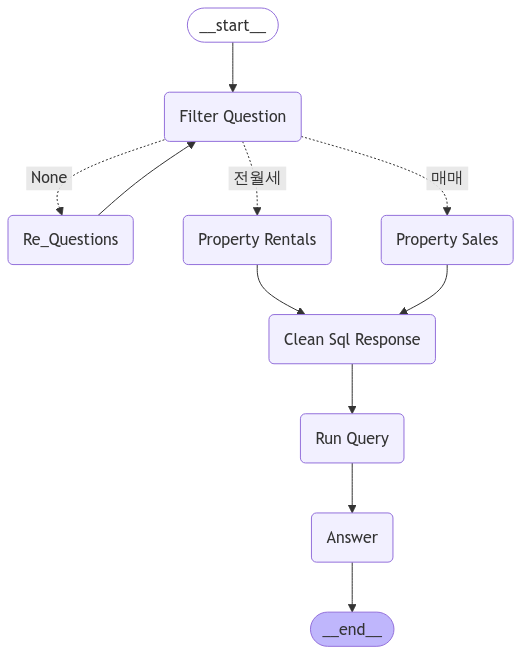

In [191]:
from IPython.display import Image, display

# 조건부 엣지 추가
graph.add_conditional_edges(
    "Filter Question",
    fiter_router,
    { 'None': "Re_Questions", '매매': "Property Sales", '전월세': 'Property Rentals'}
)

# START에서 'Filter Question' 노드로 엣지 추가
graph.add_edge(START, "Filter Question")
graph.add_edge("Re_Questions", "Filter Question")
graph.add_edge("Property Rentals", 'Clean Sql Response')
graph.add_edge("Property Sales", 'Clean Sql Response')
graph.add_edge('Clean Sql Response', 'Run Query')
graph.add_edge('Run Query', "Answer")
graph.add_edge("Answer", END)


# 그래프 컴파일
app = graph.compile()

# 그래프 실행
result = app.invoke({'questions':input()})
print(result) 


graph_image = app.get_graph().draw_mermaid_png()
display(Image(graph_image))